In [1]:
from coin import COIN

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Test Modules
## Test COIN

Simulating the COIN model
Finding optimal context labels (trial = 50)
Finding optimal context labels (trial = 100)
Finding optimal context labels (trial = 150)
Finding optimal context labels (trial = 200)
Finding optimal context labels (trial = 250)
Finding optimal context labels (trial = 300)
Permuting context labels (trial = 50)
Permuting context labels (trial = 100)
Permuting context labels (trial = 150)
Permuting context labels (trial = 200)
Permuting context labels (trial = 250)
Permuting context labels (trial = 300)


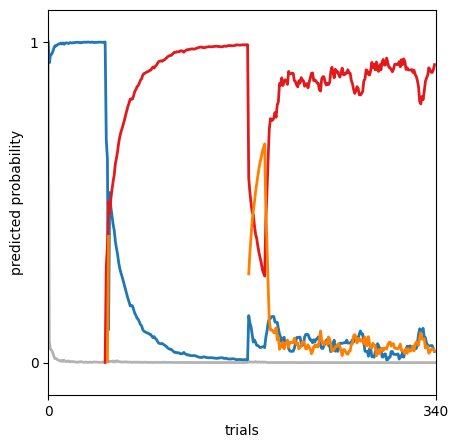

In [4]:
# Test COIN_Python
retention_values = np.linspace(0.8, 1, 500, endpoint=True)
drift_values = np.linspace(-0.1, 0.1, 500, endpoint=True)
state_values = np.linspace(-1.5, 1.5, 500, endpoint=True)
bias_values = np.linspace(-1.5, 1.5, 500, endpoint=True)
state_feedback_values = np.linspace(-1.5, 1.5, 500, endpoint=True)

store = [
    "state_feedback", "motor_output", "responsibilities", "predicted_probabilities", 
]

coin_model = COIN(
    retention_values=retention_values,
    drift_values=drift_values, 
    state_values=state_values, 
    bias_values=bias_values, 
    state_feedback_values=state_feedback_values, 
    store=store, 
    plot_predicted_probabilities = True,
)
coin_model.perturbations = np.concatenate([
    np.zeros((50, )), 
    np.ones((125, )), 
    -np.ones((15, )), 
    np.ones((150, )) * np.nan, 
])

output = coin_model.simulate_coin()

# plt.figure(figsize=(8, 5))
# plt.plot(output["runs"][0]["state_feedback"], "b.", label="state feedback")
# plt.plot(output["runs"][0]["motor_output"], "r", label="motor output")
# plt.legend()
# plt.axhline(0)

# resp = np.array(output["runs"][0]["predicted_probabilities"])
# p_contexts = np.sum(resp, axis=1)
# p_contexts = p_contexts / np.sum(p_contexts, axis=0, keepdims=True)

# plt.figure(figsize=(8, 5))
# plt.plot(p_contexts.T)

In [30]:
from itertools import permutations
from scipy.optimize import linear_sum_assignment

def _best_perm(s, typical, *, K, have_scipy=True):
    """
    Find the permutation π that minimises the Hamming distance between a
    particle sequence `s` and the reference sequence `typical`, given that
    *both* sequences contain exactly `K` distinct labels (but the numeric
    values need not coincide).

    Returns
    -------
    π : ndarray, shape (K,)
        π[j] is *the original label value* that should be mapped to the
        reference label that occupies column j in the contingency table.
        (Same contract as the original code.)
    """
    # ------------------------------------------------------------------
    # 1. Compress the two value sets to 0 … K‑1
    # ------------------------------------------------------------------
    rows = np.unique(s)          # the K distinct labels used by this particle
    cols = np.unique(typical)    # the K distinct labels in the reference

    # Safety check: if something slipped through the mode filter, bail early
    if rows.size != K or cols.size != K:
        raise ValueError("Sequences do not share the modal number of contexts")

    # Build look‑up tables value → compact index (vectorised via np.searchsorted)
    row_idx = np.searchsorted(rows, s)         # shape (T,)
    col_idx = np.searchsorted(cols, typical)   # shape (T,)

    # ------------------------------------------------------------------
    # 2. Contingency matrix in the compact K×K space
    # ------------------------------------------------------------------
    cont = np.zeros((K, K), dtype=int)
    np.add.at(cont, (row_idx, col_idx), 1)

    # ------------------------------------------------------------------
    # 3. Solve the assignment   (maximise the agreement counts)
    # ------------------------------------------------------------------
    if K > 8:
        r, c = linear_sum_assignment(-cont)    # Hungarian on the negative counts
        # π[j] should be "which *original* label from `rows` goes to col j?"
        π = np.empty(K, dtype=rows.dtype)
        π[c] = rows[r]
    else:
        # brute force for small K (K! permutations)
        perms = np.array(list(permutations(np.arange(K))), dtype=int)  # (K!, K)
        matches = (cont[np.arange(K), perms.T]).sum(0)                 # (K!,)
        best = perms[matches.argmax()]
        π = rows[best]

    return π

def label_switching_correction(prob, *, return_all=False):
    """
    Resolve label‑switching across particles by aligning every particle to the
    'typical' (medoid) particle with the minimum average Hamming distance.

    Parameters
    ----------
    prob : ndarray, shape (C, P, T)
        Posterior probabilities P(C | particle, time).
    return_all : bool, default=False
        If True, also return the list of permutations and the index of the
        typical particle.

    Returns
    -------
    prob_aligned : ndarray, shape (C, P′, T)
        `prob` with *each* particle’s context axis permuted so that contexts
        are in the same register.  Only particles that share the modal number
        of contexts are kept (exactly as in the paper).
    perms : list[np.ndarray]            (optional, if `return_all`)
        πₚ such that
        `prob_aligned[:, p, :] == prob_orig[πₚ, p, :]`.
    typical_idx : int                  (optional, if `return_all`)
        Index (w.r.t. the retained particles) of the 'typical' sequence.
    """

    C, P, T = prob.shape

    # ------------------------------------------------------------------
    # 1. Hard context sequence for every particle at every time point
    # ------------------------------------------------------------------
    seq = prob.argmax(0)             # shape (P, T) — integer labels ∈ [0, C)

    # ------------------------------------------------------------------
    # 2. Keep only particles whose *number* of distinct contexts equals the
    #    posterior mode (the “most common number of contexts” in the paper).
    # ------------------------------------------------------------------
    ctx_counts = np.array([np.unique(seq[p]).size for p in range(P)])
    mode_ctx = np.bincount(ctx_counts).argmax()
    keep_mask = ctx_counts == mode_ctx
    seq = seq[keep_mask]             # (P′, T)
    prob = prob[:, keep_mask]        # (C, P′, T)
    P = seq.shape[0]
    K = mode_ctx                     # number of contexts after restriction

    # ------------------------------------------------------------------
    # 3. Choose the 'typical' particle:
    #    the one with the minimum *average* Hamming distance to all others.
    # ------------------------------------------------------------------
    # Broadcasting gives every pairwise Boolean mismatch matrix (P,P,T)
    mism = seq[:, None, :] != seq[None, :, :]
    hamm = mism.sum(-1)              # pairwise Hamming counts  (P,P)
    typical_idx = hamm.sum(1).argmin()
    typical = seq[typical_idx]       # reference sequence (length T)

    # Identity for contexts that never appear (only matters if K < C)
    id_tail = np.arange(K, C)

    perm_list, prob_aligned = [], np.empty_like(prob)

    for p in range(P):
        π = _best_perm(seq[p], typical, K=K)
        # Build length‑C permutation: first the optimised part, then identity
        full_perm = np.concatenate((π, id_tail))
        perm_list.append(full_perm)
        prob_aligned[:, p] = prob[full_perm, p]

    if return_all:
        return prob_aligned, perm_list, typical_idx

    return prob_aligned

aligned = label_switching_correction(resp)

## Test Gymnasium and RL
### Q-Learning

Training and Visualising

Episode: 200, Avg Reward (last 200): -200.00, Epsilon: 0.819
Episode: 400, Avg Reward (last 200): -200.00, Epsilon: 0.670
Episode: 600, Avg Reward (last 200): -200.00, Epsilon: 0.549
Episode: 800, Avg Reward (last 200): -200.00, Epsilon: 0.449
Episode: 1000, Avg Reward (last 200): -200.00, Epsilon: 0.368
Episode: 1200, Avg Reward (last 200): -200.00, Epsilon: 0.301
Episode: 1400, Avg Reward (last 200): -200.00, Epsilon: 0.246
Episode: 1600, Avg Reward (last 200): -199.80, Epsilon: 0.202
Episode: 1800, Avg Reward (last 200): -199.69, Epsilon: 0.165
Episode: 2000, Avg Reward (last 200): -198.75, Epsilon: 0.135
Episode: 2200, Avg Reward (last 200): -197.95, Epsilon: 0.111
Episode: 2400, Avg Reward (last 200): -197.13, Epsilon: 0.091
Episode: 2600, Avg Reward (last 200): -196.63, Epsilon: 0.074
Episode: 2800, Avg Reward (last 200): -195.39, Epsilon: 0.061
Episode: 3000, Avg Reward (last 200): -191.69, Epsilon: 0.050
Episode: 3200, Avg Reward (last 200): -192.05, Epsilon: 0.041
Episode: 340

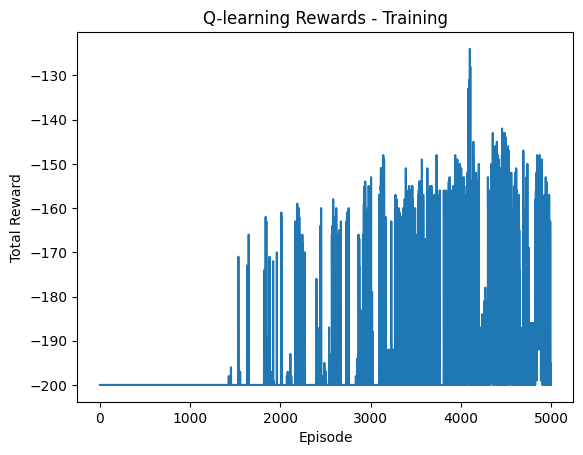

In [3]:
from environments import CustomMountainCarEnv
from rl import QLearningAgent
import matplotlib.pyplot as plt

# 1. Create the MountainCar environment
env = CustomMountainCarEnv(amplitude=1.0, force_sf=1.0, render_mode="none")

# 2. Create the Q-learning agent
agent = QLearningAgent(
    env=env,
    num_position_bins=30,
    num_velocity_bins=30,
    alpha=0.1,
    gamma=0.95,
    epsilon=1,
    epsilon_decay=0.999,
    min_epsilon=0.01
)

# 3. Train the agent
q_table, training_rewards = agent.train(
    env=env,
    n_episodes=5000,
    max_steps_per_episode=200,
    verbose=True,
    print_freq=200
)

# 4. Plot the rewards
plt.plot(training_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Q-learning Rewards - Training")
plt.show()


Visualisation

In [4]:
# Evaluate the agent and visualise
env = CustomMountainCarEnv(amplitude=1.0, force_sf=1.0, render_mode="human")

evaluation_rewards = agent.evaluate(
    env=env,
    n_episodes=1,
    max_steps_per_episode=200
)

print(f"Evaluation reward: {evaluation_rewards}")


Evaluation reward: [-195.0]


### COIN Q-Learning
Training

Simulting the COIN model


100%|██████████| 1/1 [01:01<00:00, 61.21s/it]


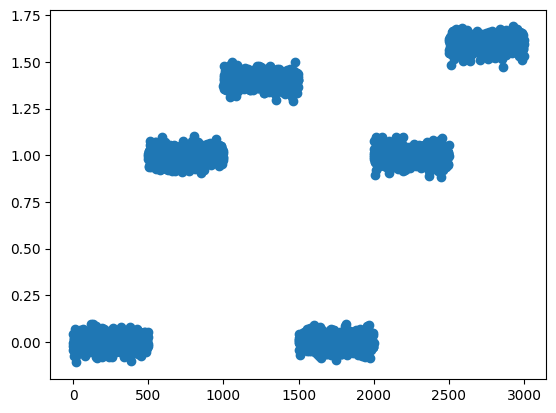

In [ ]:
# Importing and setting up contextual estimates
from coin import COIN

# Obtain contextual estimates
store = [
    "responsibilities", 
    "state_feedback",
]

# True scale factors
scale_factors = np.concatenate([
    0.0*np.ones((500, )), 
    1.0*np.ones((500, )),
    1.4*np.ones((500, )),
    0.0*np.ones((500, )),
    0.5*np.ones((500, ))
    ])

coin_model = COIN(
    prior_precision_drift=1,
    store=store
) # use default parameters for now
coin_model.perturbations = scale_factors

output = coin_model.simulate_coin()

resp = output["runs"][0]["responsibilities"]
p_context = np.sum(resp, axis=1)
p_context = p_context / np.sum(p_context, axis=0, keepdims=True)

state_feedback = output["runs"][0]["state_feedback"]
plt.scatter(
    np.arange(len(state_feedback)), 
    state_feedback
)
plt.show()


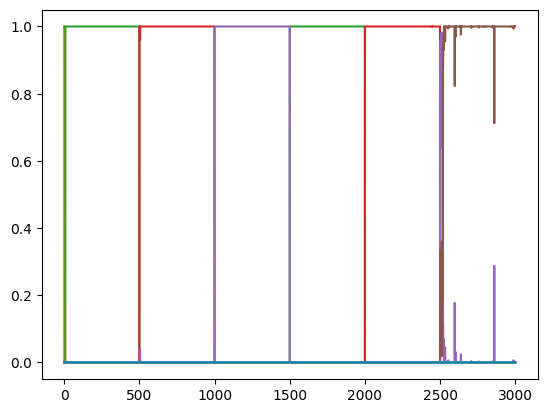

In [14]:
# Plot contextual probabilities
plt.plot(p_context.T)
plt.show()

In [15]:
from environments import CustomMountainCarEnv
from rl import COINQLearningAgent

# Begin training loop
num_episodes = p_context.shape[1]
C = p_context.shape[0]

# Create the COIN Q-learning agent
agent = COINQLearningAgent(
    env=env,
    max_contexts=C,
    num_position_bins=30,
    num_velocity_bins=30,
    alpha=0.1,
    gamma=0.99,
    epsilon=1.0,
    epsilon_decay=0.999
)

rewards = []

for i in range(0,num_episodes):
    # Create the MountainCar environment with the true amplitude
    env = CustomMountainCarEnv(amplitude=scale_factors[i], render_mode="none")

    # Train the agent in the current context
    training_reward = agent.train_step(
        env=env,
        p_context=p_context[:,i],
        max_steps_per_episode=1000,
    )

    rewards.append(training_reward)

    # Print the average training reward every 500 episodes
    if ((i+1)%500 == 0):
        print(f"Episode {i+1}, Training reward: {np.mean(rewards[-500:])}")

Episode 500, Training reward: -258.38
Episode 1000, Training reward: -827.288
Episode 1500, Training reward: -959.634
Episode 2000, Training reward: -173.968


: 

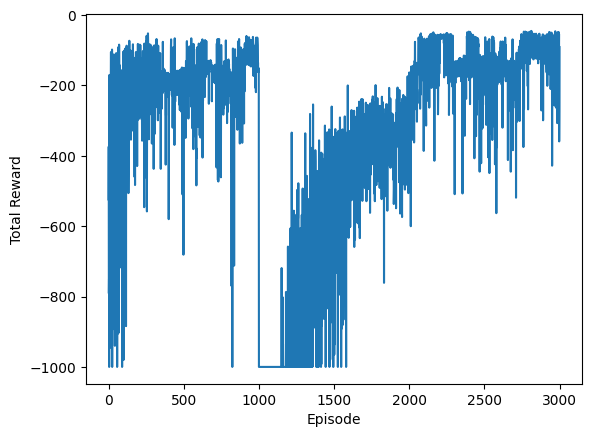

In [113]:
plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")

plt.show()

In [121]:
# Evaluate the agent and visualise
env = CustomMountainCarEnv(amplitude=1.00, force_sf=1.0, render_mode="human")
evaluation_rewards = agent.evaluate(
    env=env,
    p_context=p_context[:,1750],
    n_episodes=1,
    max_steps_per_episode=1000
)

Qdat = agent.Qdat.copy()

print(f"Evaluation reward: {evaluation_rewards}")

Evaluation reward: [-209.0]


### PPO
Training and Importing

In [163]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal
import numpy as np
import collections

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters (you can tune these)
learning_rate = 3e-4
gamma = 0.99
gae_lambda = 0.95
clip_epsilon = 0.2
ppo_epochs = 10
num_episodes = 200
rollout_steps = 2048
mini_batch_size = 64

# Actor-Critic network
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=64):
        super(ActorCritic, self).__init__()
        
        # Common feature extractor
        self.common = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
        )
        
        # Actor head
        self.mu = nn.Linear(hidden_dim, action_dim)
        self.log_std_param = nn.Parameter(torch.zeros(action_dim))
        
        # Critic head
        self.critic = nn.Linear(hidden_dim, 1)
        
    def forward(self, state):
        x = self.common(state)
        mu = self.mu(x)
        log_std = self.log_std_param
        value = self.critic(x)
        return mu, log_std, value
    
    def get_action(self, state):
        with torch.no_grad():
            mu, log_std, _ = self.forward(state)
            dist = Normal(mu, log_std.exp())
            action = dist.sample()
        return action.cpu().numpy(), dist.log_prob(action).sum(dim=-1).cpu().numpy()
    
    def evaluate_actions(self, states, actions):
        mu, log_std, value = self.forward(states)
        dist = Normal(mu, log_std.exp())
        
        log_probs = dist.log_prob(actions).sum(dim=-1)
        entropy = dist.entropy().sum(dim=-1)
        return log_probs, entropy, value.squeeze(-1)

# Replay buffer for PPO
class PPOMemory:
    def __init__(self):
        self.states = []
        self.actions = []
        self.log_probs = []
        self.rewards = []
        self.dones = []
        self.values = []
    
    def store(self, state, action, log_prob, reward, done, value):
        self.states.append(state)
        self.actions.append(action)
        self.log_probs.append(log_prob)
        self.rewards.append(reward)
        self.dones.append(done)
        self.values.append(value)
    
    def clear(self):
        self.states = []
        self.actions = []
        self.log_probs = []
        self.rewards = []
        self.dones = []
        self.values = []

def compute_gae(next_value, rewards, dones, values):
    """
    Computes Generalized Advantage Estimation (GAE)
    """
    advantages = []
    gae = 0
    for i in reversed(range(len(rewards))):
        delta = rewards[i] + gamma * (1 - dones[i]) * next_value - values[i]
        gae = delta + gamma * gae_lambda * (1 - dones[i]) * gae
        advantages.insert(0, gae)
        next_value = values[i]
    return advantages

# Instantiate environment and model
env = gym.make("Pendulum-v1")
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]

agent = ActorCritic(obs_dim, act_dim).to(device)
optimizer = optim.Adam(agent.parameters(), lr=learning_rate)

memory = PPOMemory()

# Training loop
episode_rewards = []

for episode in range(num_episodes):
    state, _ = env.reset()
    done = False
    ep_reward = 0
    
    for t in range(rollout_steps):
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            mu, log_std, value = agent.forward(state_tensor)
            dist = Normal(mu, log_std.exp())
            action = dist.sample()
            log_prob = dist.log_prob(action).sum(dim=-1)
        
        action_clipped = action.cpu().numpy()[0]
        next_state, reward, done, truncated, info = env.step(action_clipped)
        
        memory.store(
            state,
            action_clipped,
            log_prob.item(),
            reward,
            float(done or truncated),
            value.item()
        )
        
        state = next_state
        ep_reward += reward
        if done or truncated:
            break
    
    episode_rewards.append(ep_reward)
    
    # Compute advantage for the collected rollout
    # Note: if we ended due to done/truncated, next_value is typically 0 or the critic's estimate of the next_state
    next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0).to(device)
    with torch.no_grad():
        _, _, next_value = agent.forward(next_state_tensor)
    next_value = next_value.item()
    
    advantages = compute_gae(next_value,
                             memory.rewards,
                             memory.dones,
                             memory.values)
    returns = [adv + val for adv, val in zip(advantages, memory.values)]
    
    # Convert rollout to tensors
    states = torch.FloatTensor(memory.states).to(device)
    actions = torch.FloatTensor(memory.actions).to(device)
    old_log_probs = torch.FloatTensor(memory.log_probs).to(device)
    advantages = torch.FloatTensor(advantages).to(device)
    returns = torch.FloatTensor(returns).to(device)
    
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
    
    # PPO update
    dataset_size = len(states)
    for _ in range(ppo_epochs):
        # Shuffle indices for mini-batches
        indices = np.arange(dataset_size)
        np.random.shuffle(indices)
        
        for start in range(0, dataset_size, mini_batch_size):
            end = start + mini_batch_size
            mb_indices = indices[start:end]
            
            mb_states = states[mb_indices]
            mb_actions = actions[mb_indices]
            mb_old_log_probs = old_log_probs[mb_indices]
            mb_advantages = advantages[mb_indices]
            mb_returns = returns[mb_indices]
            
            log_probs, entropy, value = agent.evaluate_actions(mb_states, mb_actions)
            ratio = torch.exp(log_probs - mb_old_log_probs)
            
            surr1 = ratio * mb_advantages
            surr2 = torch.clamp(ratio, 1.0 - clip_epsilon, 1.0 + clip_epsilon) * mb_advantages
            actor_loss = -torch.min(surr1, surr2).mean()
            
            critic_loss = nn.MSELoss()(value, mb_returns)
            
            loss = 0.5 * critic_loss + actor_loss - 0.01 * entropy.mean()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
    memory.clear()
    
    print(f"Episode {episode+1}/{num_episodes}, Reward: {ep_reward:.2f}")

env.close()

print("Training finished.")
print("Episode rewards:", episode_rewards)


C:\Users\richa\AppData\Local\Temp\ipykernel_28428\3818780698.py:160: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  states = torch.FloatTensor(memory.states).to(device)


Episode 1/200, Reward: -1510.70
Episode 2/200, Reward: -1172.47
Episode 3/200, Reward: -1109.28
Episode 4/200, Reward: -1257.14
Episode 5/200, Reward: -1133.54
Episode 6/200, Reward: -1061.44
Episode 7/200, Reward: -1596.25
Episode 8/200, Reward: -1183.48
Episode 9/200, Reward: -1244.43
Episode 10/200, Reward: -1201.15
Episode 11/200, Reward: -1180.55
Episode 12/200, Reward: -1230.61
Episode 13/200, Reward: -1228.86
Episode 14/200, Reward: -1054.75
Episode 15/200, Reward: -1044.86
Episode 16/200, Reward: -1321.39
Episode 17/200, Reward: -1422.80
Episode 18/200, Reward: -1100.04
Episode 19/200, Reward: -1661.75
Episode 20/200, Reward: -1782.21
Episode 21/200, Reward: -1233.77
Episode 22/200, Reward: -1414.93
Episode 23/200, Reward: -1573.86
Episode 24/200, Reward: -1302.31
Episode 25/200, Reward: -1750.03
Episode 26/200, Reward: -1395.63
Episode 27/200, Reward: -1450.43
Episode 28/200, Reward: -1377.78
Episode 29/200, Reward: -1539.45
Episode 30/200, Reward: -1369.64
Episode 31/200, Rew

Visualising

In [1]:
import gymnasium as gym
from gymnasium.envs.classic_control.pendulum import PendulumEnv

env = PendulumEnv(render_mode="human")  # or 'rgb_array' in some environments
env.l = 5.0
state, _ = env.reset()
done = False

while not done:
    state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
    action, _ = agent.get_action(state_tensor)
    action = action[0]
    state, reward, done, truncated, info = env.step(action)
    if done or truncated:
        break

env.close()


NameError: name 'torch' is not defined